# Programming Project

This notebook demonstrates how the 'fastqstats' package processes FASTQ files, calculates quality metrics, and outputs summaries. It is a supplement to the command-line interface which explains the development process.

## Import

We import the required packages.

In [5]:
import numpy as np
import pandas as pd
import os
import statistics

## Read in Fastq file

We start by loading in the FASTQ file. The function reads the whole file in by line, including reads sequences and quality scores.

In [6]:
def read_fastq(fastq_file):
    """
    Reads in a FASTQ file by line.

    Args:
        fastq_file (str): Path to a FASTQ file.

    Returns:
        lines: A list of strings where each string is a line from the file.
    """
    with open(fastq_file, "r") as file:
        lines = file.readlines()
    return lines

In [33]:
fastqfile = read_fastq("Fastq_qc_sum_program/fastqstats/Example_files/adapter_content.fastq")
print(fastqfile[1:10])

['ATTATTTCGCTGCTGGCGATTTCCGGGGTGTTCTTC\n', '+\n', 'EFFFFFEGGGGFGEEE?DE?DD5D:CBA@ACDA=?2\n', '@SRR576933.1806578 HWUSI-EAS1789_0000:2:52:11498:11427/1\n', 'ATAGCTGTCAGTACGGGAAAGGCTGATGTAGTTCTC\n', '+\n', 'DGGGGGGGGGFGGGGGGGGGFGFGGGGFGGGGGGG<\n', '@SRR576933.817682 HWUSI-EAS1789_0000:2:36:9204:6426/1\n', 'ACTGACGAGACGCTGATATGTTTCAGAATTATTTTA\n']


## Extract sequences (bases)

The nucleotide sequences are extraced and stored in a NumPy array for per-base analysis. The array can be used to calculate total reads and average read length for example.

In [34]:
def array_seq(fastqdata):
    """
    Extracts all sequence lines from FASTQ data and convert them to ASCII format bases.

    FASTQ files store reads in groups of four lines where the 2nd line contains the sequence
    (index 1, 5, 9, ...). This function extracts the sequences and converts each character base
    to its ASCII interger.

    Args:
        fastqdata (list[str]): Lines from a FASTQ file where every fourth line contains a 
        sequence.
        
    Returns:
        np.ndarray: A 2D uint8 array of shape (num_reads, read_length) where every element is 
        a base in ASCII format.
    """
    seq_lines = [
        [ord(base) for base in line.strip()]#Turn bases into numbers 'A'=65, 'C'=67, 'G'=71, 'T'=84 
        for i, line in enumerate(fastqdata)
        if i % 4 == 1 #Takes every fourth lines starting from index 1 (first line with sequence)
    ]
    return np.array(seq_lines, dtype=np.uint8)       

In [35]:
seq_array = array_seq(read_fastq("Fastq_qc_sum_program/fastqstats/Example_files/adapter_content.fastq")) #create array of nucleotides in ASCII format
print(len(seq_array))#total number of reads in the fastq

#Calculate average length of reads
total = sum(len(i) for i in seq_array) 
average = total / len(seq_array)
print(f"The average length of reads is {round(average)}bp")

seq_array.shape

50000
The average length of reads is 36bp


(50000, 36)

In [9]:
df = pd.DataFrame(seq_array)
print(df.head())

   0   1   2   3   4   5   6   7   8   9   ...  26  27  28  29  30  31  32  \
0  65  84  84  65  84  84  84  67  71  67  ...  71  71  84  71  84  84  67   
1  65  84  65  71  67  84  71  84  67  65  ...  84  71  84  65  71  84  84   
2  65  67  84  71  65  67  71  65  71  65  ...  65  65  84  84  65  84  84   
3  65  65  65  84  84  84  65  84  65  84  ...  65  84  65  84  84  71  67   
4  65  67  65  65  71  65  84  67  84  71  ...  67  67  65  65  84  67  65   

   33  34  35  
0  84  84  67  
1  67  84  67  
2  84  84  65  
3  84  84  71  
4  67  65  84  

[5 rows x 36 columns]


## Extract scores

The quality scores are extracted and converted from ASCII to Phred scores and stored in a separate NumPy array. This can be used to calculate quality per base and per read.

In [10]:
def array_scores(fastqdata):
    """
    Extracts all scores lines from FASTQ data and converts them to phred scores.

    FASTQ files store reads in groups of four lines where the 4th line contains the scoring
    in ASCII format (index 3, 7, 11, ...). This function extracts the score line and converts 
    each ASCII encoded score value to its corresponding phred score by subtractubg 33.
    
    Args:
        fastqdata (list[str]): Lines from a FASTQ file where every fourth line contains the
        ASCII-encoded base quality scores.
        
    Returns:
        np.ndarray: A 2D uint8 array of shape (num_reads, read_length) where each element is 
        the Phred quality score for a base.
    """
    scores_lines = [
        [ord(char) - 33 for char in line.strip()]#converts ASCII to phred scores
        for i, line in enumerate(fastqdata)
        if i % 4 == 3 #Takes every fourth lines starting from index 3 (first line with scores)
    ]            
    return np.array(scores_lines, dtype=np.uint8)#shape (nreads, readlen), data type 8 bit

In [12]:
score_arr = array_scores(read_fastq("Fastq_qc_sum_program/fastqstats/Example_files/adapter_content.fastq"))
score_arr.shape #50000 reads that are 36 bases long.

(50000, 36)

In [13]:
df = pd.DataFrame(score_arr)
print(df.head())

   0   1   2   3   4   5   6   7   8   9   ...  26  27  28  29  30  31  32  \
0  36  37  37  37  37  37  36  38  38  38  ...  33  32  31  32  34  35  32   
1  35  38  38  38  38  38  38  38  38  38  ...  38  37  38  38  38  38  38   
2  38  38  38  38  37  38  38  38  38  37  ...  38  37  38  38  38  38  38   
3  38  38  38  38  38  38  38  38  38  38  ...  38  38  38  38  38  38  38   
4  38  38  38  38  38  38  38  37  38  38  ...  38  38  38  38  38  38  37   

   33  34  35  
0  28  30  17  
1  38  38  27  
2  38  38  26  
3  38  38  31  
4  38  38  26  

[5 rows x 36 columns]


In [14]:
avg_per_read = score_arr.mean(axis=1)#mean quality per read
avg_per_base = score_arr.mean(axis=0)#mean quality per base position
med_per_read = np.median(score_arr, axis=1)
med_per_base = np.median(score_arr, axis=0)
print(round((sum(avg_per_read))/len(avg_per_read)))#mean of means per read. Maybe use for quality assessment < for fail <27 for warning
print(min(med_per_base))#Use this to set threshold for Per Base Sequence quality <20 for fail <27 for warning

35
21.0


## GC content

GC content is calculated as the proportion of G and C bases across all reads.

In [38]:
gc_mask = np.sum((seq_array == ord('G')) | (seq_array == ord('C')))

#Calculate GC content
total_bases = seq_array.size
total_gc_content = gc_mask / total_bases
print(f"The GC content is {round(total_gc_content * 100, 2)}%")

The GC content is 49.89%


## Base frequencies per position

Base frequencies per position are computed to identify biases in sequences at specific positions. A large difference in base frequency at a given position can indicate nucleotide bias.

In [16]:
def base_freq(seq_array):
    """
    Calculates per-base frequencies  and the maximum frequency difference at each position.

    For each position in the sequence reads, this function calculates the frequency of each
    nucleotide (A, C, G, T). The difference between the maximum and minumum nucleotide 
    frequencies at each position is also calculated for quality assessment.

    Args: 
        seq_array(np.ndarray): A 2D numpy array of shape (num_reads, read_length) containing
        the nucleotide for each position in ASCII format.

    Returns:
        diffs(np.ndarray): A 1D array of length read_length, where each value is the 
        maximum difference between two nucleotides at each position in the read.
        Higher values might indicate a bias at that position.
    """
    
    bases = ['A', 'C', 'G', 'T']
    base_codes = np.array([ord(b) for b in bases], dtype=np.uint8)

    #Count bases per position
    #Create a 2D array (4 x num_positions) of counts
    base_counts = np.vstack([
        (seq_array == code).sum(axis=0)
        for code in base_codes
    ])

    #Calculate frequencies
    total_counts = base_counts.sum(axis=0)
    base_freq = base_counts / total_counts  # shape (4, num_positions)

    #Calculate per-position frequency differences
    diffs = base_freq.max(axis=0) - base_freq.min(axis=0)

    return diffs

In [39]:
diffs = base_freq(seq_array)
print(diffs)

[0.30704763 0.33258    0.32776    0.29852    0.32828    0.3086
 0.34464    0.33548    0.31906    0.32944    0.31166    0.3232
 0.33006    0.32364    0.32376    0.3152     0.31076    0.32318
 0.31812    0.31814    0.31428    0.32463948 0.32184    0.30973858
 0.3191     0.30636613 0.32088    0.32891316 0.32292    0.31265251
 0.31085243 0.32132    0.30938619 0.32332647 0.31297878 0.31268625]


## Adapter Identifier

Reads are scanned at the 5' and 3' ends for known adapter sequences. The proportion of read containing adapters is reported as an indicator of contamination.

In [40]:
def adapter_find(seq_array):
    """
    Identifies and counts the pressence of common adapter sequences in sequencing reads.
    
    This function scans each read in the FASTQ file for known adapter sequences.
    A match is counted if an adapter sequence is present at the beginning (5') or en (3')
    of a read. The proportion of adapter sequences present in FASTQ file might indicate 
    adapter contaminations which might need to be removed before downstream analysis.
    
    Adapter sequences source: 
        •	Illumina Universal Adapter—AGATCGGAAGAG
        •	Illumina Small RNA 3' Adapter—TGGAATTCTCGG
        •	Illumina Small RNA 5' Adapter—GATCGTCGGACT
        •	Nextera Transposase Sequence—CTGTCTCTTATA
    
    Args: 
        seq_array(np.ndarray): A 2D numpy array of shape (num_reads, read_length) containing
        the nucleotide for each position in ASCII format.

    Returns:
        adapter_counts(dict[str, int]: A dictionary mapping each given adapter sequence
        to the number of times it appears at the start or end of a read in the FASTQ file.
    """

    adapters = ["AGATCGGAAGAG","TGGAATTCTCGG","GATCGTCGGACT","CTGTCTCTTATA"]
    adapter_counts = {adapter:0 for adapter in adapters}

    #Reads one row at a time
    for row in seq_array:
        read = "".join(map(chr, row))

        #Count number of common adapter seq that appears at start or end
        for adapter in adapters:
            if read.startswith(adapter) or read.endswith(adapter):
                adapter_counts[adapter] += 1

    return adapter_counts 

In [41]:
adapt_ident = adapter_find(seq_array)
print(adapt_ident)

{'AGATCGGAAGAG': 0, 'TGGAATTCTCGG': 0, 'GATCGTCGGACT': 0, 'CTGTCTCTTATA': 0}


## Main script

The `stats_fastq` function ties together all steps:

- Reading FASTQ
- Extracing sequences and quality
- Computing metrics
- Classifying results
- Writing summary to a text file

This function is also called by the command-line interface.

In [42]:
def stats_fastq(
    fastq_path,
    base_quality_warn = 28,
    base_quality_fail = 20,
    base_content_warn = 0.10,
    base_content_fail = 0.20,
    read_quality_warn = 28,
    read_quality_fail = 20,
    adapter_warn = 0.05,
    adapter_fail = 0.10):
    """
     Computes summary statistics and quality assessment for a FASTQ file.
    
    This function reads a FASTQ file, extracts sequences and quality scores, 
    and caulculates overall and per-base metrics for quality control. Metrics 
    include per-base sequence quality, per-base nucleotide composition, 
    per-read average quality, adapter contamination, and GC content.
    Each metric is compared against user-defined warning and failure thresholds
    to producde a qualitative assessment (PASS, Warning, FAIL) per metric. The
    results are written to a summary text file named "<filename>_summary.txt"
    
    Args:
        fastq_path (str): Path to the FASTQ file to analyze.
        base_quality_warn (int, optional): Warning threshold for per-base quality scores. Defaults to 28.
        base_quality_fail (int, optional): Failure threshold for per-base quality scores. Defaults to 20.
        base_content_warn (float, optional): Warning threshold for per-base nucleotide bias. Defaults to 0.10.
        base_content_fail (float, optional): Failure threshold for per-base nucleotide bias. Defaults to 0.20.
        read_quality_warn (int, optional): Warning threshold for per-read average quality. Defaults to 28.
        read_quality_fail (int, optional): Failure threshold for per-read average quality. Defaults to 20.
        adapter_warn (float, optional): Warning threshold for adapter content. Defaults to 0.05.
        adapter_fail (float, optional): Failure threshold for adapter content. Defaults to 0.10.
    
    Returns:
        str: The filename of the summary text file generated by the function, containing
        both quantitative statistics and qualitative quality assessments.
    """
    #Extract filename
    filename = os.path.basename(fastq_path)

    #Read in and process
    fastq_data = read_fastq(fastq_path)
    seq_array = array_seq(fastq_data)
    score_array = array_scores(fastq_data) 

    #Statistics
    #For summary
    total_seq = len(seq_array)
    read_length = round((sum(len(i) for i in seq_array)) / len(seq_array))
    total_bases = (total_seq * read_length) / 1000000
    gc_content = round((np.sum((seq_array == ord('G')) | (seq_array == ord('C')))) / (seq_array.size) * 100, 2)
    #For Quality assesment
    base_quality = min(np.median(score_array, axis=0))
    base_content = base_freq(seq_array)
    read_quality = round((sum(score_array.mean(axis=1)))/len(score_array.mean(axis=1)))
    adapter_content = np.array(list(adapter_find(seq_array).values())) / total_seq
    
    
    #Results output
    results_file = filename + "_summary.txt"
    with open(results_file, "w") as r:
        #Summary fastq
        r.write(f" Summary \n")
        r.write(f"Filename: {filename}\n")
        r.write(f"Total Sequences: {total_seq}\n")
        r.write(f"Total Bases: {total_bases}Mbp\n")
        r.write(f"Average Length: {read_length}bp\n")
        r.write(f"GC content: {gc_content}%\n")


        # Per Base Sequence Quality
        if base_quality < base_quality_fail:
            base_quality_status = "FAIL"
        elif base_quality < base_quality_warn:
            base_quality_status = "Warning"
        else:
            base_quality_status = "PASS"

        r.write(f"Per Base Sequence Quality: {base_quality_status} \n")

        # Per Base Sequence Content
        max_base_content = np.max(base_content)
        if max_base_content > base_content_fail:
            base_content_status = "FAIL"
        elif max_base_content > base_content_warn:
            base_content_status = "Warning"
        else:
            base_content_status = "PASS"

        r.write(f"Per Base Sequence content: {base_content_status} \n")
        
        # Per Read Quality
        if read_quality < read_quality_fail:
            read_quality_status = "FAIL"
        elif read_quality < read_quality_warn:
            read_quality_status = "Warning"
        else:
            read_quality_status = "PASS"

        r.write(f"Per Read Quality: {read_quality_status} \n")

        # Adapter Content
        max_adapter_content = np.max(adapter_content)
        if max_adapter_content > adapter_fail:
            adapter_status = "FAIL"
        elif max_adapter_content > adapter_warn:
            adapter_status = "Warning"
        else:
            adapter_status = "PASS"

        r.write(f"Adapter content: {adapter_status} \n")

    return results_file

In [43]:
stats_fastq("Fastq_qc_sum_program/fastqstats/Example_files/adapter_content.fastq")

'adapter_content.fastq_summary.txt'

In [44]:
with open ("adapter_content.fastq_summary.txt", "r") as file:
    content = file.read()
    print(content)

 Summary 
Filename: adapter_content.fastq
Total Sequences: 50000
Total Bases: 1.8Mbp
Average Length: 36bp
GC content: 49.89%
Per Base Sequence Quality: Warning 
Per Base Sequence content: FAIL 
Per Read Quality: PASS 
Adapter content: PASS 



## Plots

By using the score array you could plot the quality metrics per base or per read. The first plot show the quality per base on reads of length 36. The second plot shows the average quality for each read.

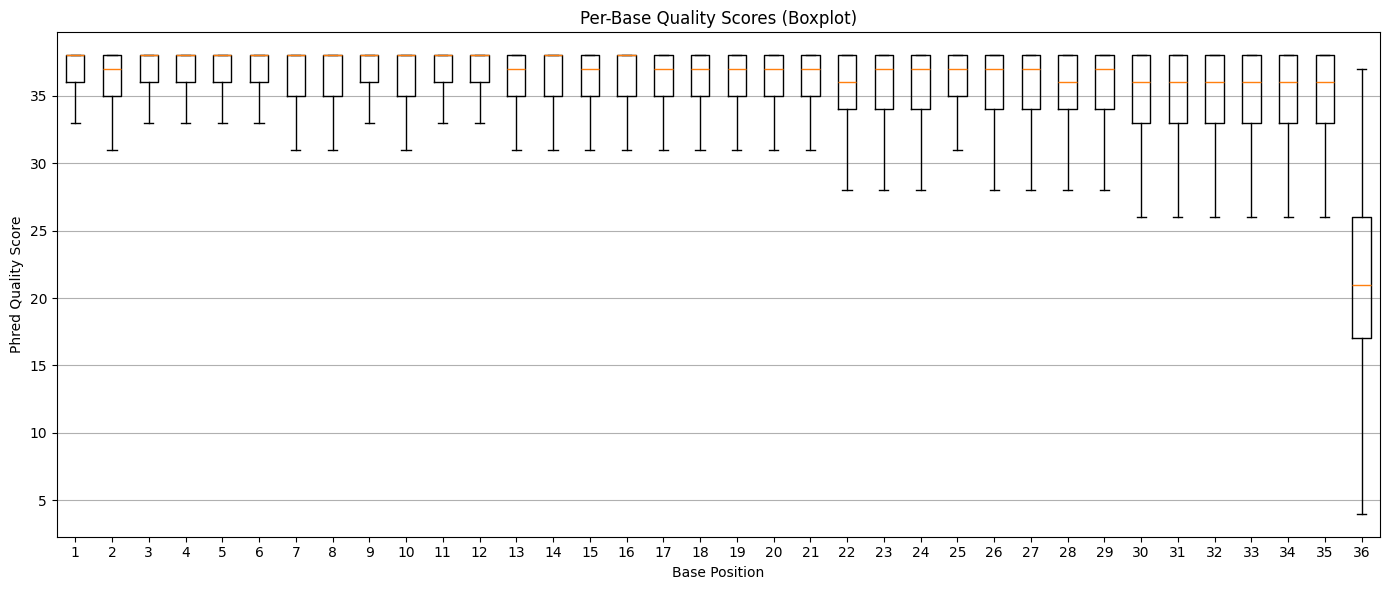

In [45]:
import matplotlib.pyplot as plt

# Turn columns into lists for boxplot
per_base_scores = [score_arr[:, i] for i in range(score_arr.shape[1])]

plt.figure(figsize=(14, 6))
plt.boxplot(per_base_scores, positions=range(1, len(per_base_scores)+1), showfliers=False)
plt.title('Per-Base Quality Scores (Boxplot)')
plt.xlabel('Base Position')
plt.ylabel('Phred Quality Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


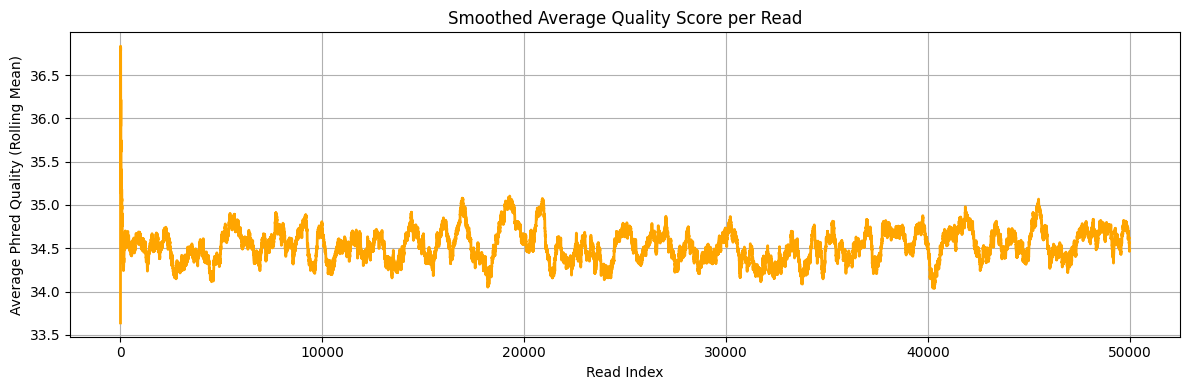

In [46]:
rolling_avg = pd.Series(avg_per_read).rolling(window=500, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_avg, color='orange', linewidth=2)
plt.title('Smoothed Average Quality Score per Read')
plt.xlabel('Read Index')
plt.ylabel('Average Phred Quality (Rolling Mean)')
plt.grid(True)
plt.tight_layout()
plt.show()



## Conclusion

This notebook demontrates the inner working of `fastqstats` for quality control. It also explains the overall development process of the program and how the functions were intended to be used. For quick testing, the CLI version (`fastqstats path/to/file.fastq`) can be used.